(load-project-yaml-from-git)=
# Load project YAML from Git, Zip, Tar source

After you create your project and you have a project.yaml file with all the necessery metadata within the remote source (Git, zip or gz.tar file), you can simply load that project and run, build, and deploy your functions and workflows.

Run the project automation in {ref}`automate-project-git-source` before you run this workbook.

This notebook presents the steps to load a CI/CD project in MLRun:
1. [Loading a project from a remote URL](#loading-a-project-from-a-remote-url)
2. [Getting a function object](#getting-a-function-object)
3. [Running project functions](#running-project-functions)
5. [Deploying project functions](#deploying-project-functions)
6. [Running the project workflow](#running-the-project-workflow)

Install mlrun using ``pip install mlrun==<mlrun server version>`` or ``sh align_mlrun.sh`` (the default mlrun installer that automatically installs the server version).

In [1]:
import mlrun

## Loading a project from a remote URL

This method can be used for loading an MLRun project from yaml/zip/tar/git/dir or from the MLRun DB.

In [2]:
# project source to load from -'git://url/org/repo.git#<branch-name or refs/heads/.. or refs/tags/..>`.
source = "git://github.com/mlrun/ci-cd-tutorial.git#refs/tags/v3"

**Note -** Add the git branch or refs to the source e.g.: 'git://<url>/org/repo.git#<branch-name or refs/heads/..>'

In [3]:
# load the project
project = mlrun.load_project(
    "./clone", url=source, clone=True, name="my-load-proj", user_project=True
)

For example:
```
# when loading from private repo
project = mlrun.get_or_create_project(name='new-ci-cd-proj',context='./',init_git=True,secrets={"GIT_TOKEN":<github-token>})
# when running functions in a project from a private repo
project.set_secrets({"GIT_TOKEN":<github-token>}
```

See {py:class}`mlrun.projects.load_project`.

In [4]:
# print project yaml
print(project.to_yaml())

kind: project
metadata:
  name: my-load-proj-shapira
  created: '2023-04-17T13:27:10.756000'
spec:
  functions:
  - url: ./src/data_fetch.py
    name: data-fetch
    kind: job
    image: mlrun/mlrun
    handler: data_fetch
    with_repo: true
    tag: v2
  - url: ./src/train.py
    name: train
    kind: job
    image: mlrun/mlrun
    handler: train
    with_repo: true
    tag: v2
  - url: ./function_spec/serving.yaml
    name: serving
  workflows:
  - path: ./src/workflow.py
    name: main
  artifacts:
  - kind: model
    metadata:
      project: new-ci-cd-proj-shapira
      key: model-test
    spec:
      target_path: v3io:///projects/new-ci-cd-proj-shapira/artifacts/a5d545c6-fd5d-44e8-966c-24b9261314be/train/0/model/
      model_file: model.pkl
    status:
      state: created
  conda: ''
  source: git://github.com/GiladShapira94/example-ci-cd.git#refs/heads/v2
  origin_url: git://github.com/GiladShapira94/example-ci-cd.git#refs/heads/v2
  load_source_on_run: true
  desired_state: on

## Getting a function object 
Get the function object using the {py:class}`~mlrun.projects.MlrunProject.get_function` method.

This method allows you to get a function object based on the metadata in your project YAML file or from MLRun DB.
````
serving_func = project.get_function('<function name>')
````

In [8]:
serving_func = project.get_function("serving")

In [10]:
serving_func.add_model(
    key="model",
    model_path=train_run.outputs["model"],
    class_name="mlrun.frameworks.sklearn.SklearnModelServer",
)

```{admonition} Tip: Changing the model file path
This serving function points to a model file whose path is stored in the function spec. If you want to change it (for example, to use a newer model file) you need to add the model to the function object and then deploy the function, or alternately, change the function.yaml in the remote source:


      serving_func = project.get_function('serving')
      serving_func.add_model(key='model',model_path=train_run.outputs["model"],
      class_name='mlrun.frameworks.sklearn.SklearnModelServer')
      serving_dep = project.deploy_function('serving')
```

Test your serving function locally before deploying it.

In [11]:
serving_server = serving_func.to_mock_server()

> 2023-05-17 09:19:19,976 [warning] run command, file or code were not specified
> 2023-05-17 09:19:20,579 [info] model model was loaded
> 2023-05-17 09:19:20,580 [info] Loaded ['model']


In [12]:
my_data = """{"inputs":[[-0.60150011,  0.51150308,  0.25701239, -1.51777297, -1.82961288,
         0.22983693, -0.40761625,  0.82325082,  1.1779216 ,  1.08424275,
        -0.7031145 , -0.40608979, -0.36305977,  1.28075006,  0.94445967,
         1.19105828,  1.93498414,  0.69911167,  0.50759757,  0.91565635]]}"""

In [13]:
serving_server.test("/", my_data)

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


{'id': '70c310d8fc10420fa9887546623b0ee0',
 'model_name': 'model',
 'outputs': [1]}

## Running project functions 
Run the function using the {py:class}`~mlrun.projects.MlrunProject.run_function` method both to 
[run jobs locally](./automate-project-git-source.html#running-the-function-locally) 
and, run remotely on the [runtime/cluster](./automate-project-git-source.html#running-the-function-remotely-on-your-cluster). If 
there are any requirements you need to build a new 
image before you run a function. See more details in {ref}`build-function-image`.

In [5]:
project.run_function(
    function="data-fetch", local=True, returns=["train-dataset", "test-dataset"]
)

> 2023-05-17 09:15:38,824 [info] Storing function: {'name': 'data-fetch-data-fetch', 'uid': '5bd1b1e535894b1385ed1d6d33180741', 'db': 'http://mlrun-api:8080'}


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
my-load-proj-shapira,...33180741,0,May 17 09:15:38,completed,data-fetch-data-fetch,v3io_user=shapirakind=owner=shapirahost=jupyter-shapira-7fc985f9db-cp8x9release=v2,,,,train-datasettest-dataset


> 2023-05-17 09:15:42,712 [info] run executed, status=completed: {'name': 'data-fetch-data-fetch'}


In [6]:
data_fetch_run = project.run_function(
    function="data-fetch", local=False, returns=["train-dataset", "test-dataset"]
)

> 2023-05-17 09:15:42,766 [info] Storing function: {'name': 'data-fetch-data-fetch', 'uid': 'bb814e47e2cd433b8820f19c782fb8af', 'db': 'http://mlrun-api:8080'}
> 2023-05-17 09:15:43,048 [info] Job is running in the background, pod: data-fetch-data-fetch-q774n
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
my-load-proj-shapira,...782fb8af,0,May 17 09:15:47,completed,data-fetch-data-fetch,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.3.1-rc5mlrun/client_python_version=3.7.6host=data-fetch-data-fetch-q774nrelease=v2,,,,train-datasettest-dataset


> 2023-05-17 09:15:56,204 [info] run executed, status=completed: {'name': 'data-fetch-data-fetch'}


In [7]:
train_run = project.run_function(
    function="train",
    inputs={
        "train_data": data_fetch_run.outputs["train-dataset"],
        "test_data": data_fetch_run.outputs["test-dataset"],
    },
)

> 2023-05-17 09:15:56,355 [info] Storing function: {'name': 'train-train', 'uid': 'b0b6137768c74af2b115b4399ee596e5', 'db': 'http://mlrun-api:8080'}
> 2023-05-17 09:15:56,743 [info] Job is running in the background, pod: train-train-vzxw9
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
my-load-proj-shapira,...9ee596e5,0,May 17 09:16:02,completed,train-train,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.3.1-rc5mlrun/client_python_version=3.7.6host=train-train-vzxw9release=v2,train_datatest_data,,accuracy=0.85f1_score=0.88precision_score=0.7857142857142857recall_score=1.0,feature-importancetest_setconfusion-matrixroc-curvescalibration-curvemodel


> 2023-05-17 09:16:18,044 [info] run executed, status=completed: {'name': 'train-train'}


## Deploying project functions
To deploy a remote function e.g. nuclio or serving function, use the {py:class}`~mlrun.projects.MlrunProject.deploy_function` method. 
You must use this method before invoking Nuclio or serving functions.
````
nuclio_func=project.deploy_function(function='<function name>')

nuclio_func.function.invoke('/',{'int':4})
````

In [14]:
serving_dep = project.deploy_function("serving")

> 2023-05-17 09:19:25,799 [info] Starting remote function deploy
2023-05-17 09:19:26  (info) Deploying function
2023-05-17 09:19:26  (info) Building
2023-05-17 09:19:26  (info) Staging files and preparing base images
2023-05-17 09:19:26  (info) Building processor image
2023-05-17 09:20:41  (info) Build complete
2023-05-17 09:21:19  (info) Function deploy complete
> 2023-05-17 09:21:27,112 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-my-load-proj-shapira-serving-v2.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['my-load-proj-shapira-serving-v2-my-load-proj-shapira.default-tenant.app.cust-cs-il-3-5-2.iguazio-cd2.com/']}


In [15]:
serving_dep.function.invoke("/", my_data)

> 2023-05-17 09:21:27,192 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-my-load-proj-shapira-serving-v2.default-tenant.svc.cluster.local:8080/'}


{'id': 'efb4e274-00c2-428d-b462-92222bc64ce5',
 'model_name': 'model',
 'outputs': [1]}

## Running the project workflow

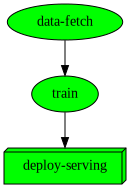

uid,start,state,name,parameters,results
...fe1ce62b,May 17 09:22:14,completed,train,,accuracy=0.8f1_score=0.7999999999999999precision_score=0.7272727272727273recall_score=0.8888888888888888
...dd17518b,May 17 09:21:43,completed,data-fetch,,


b6ebe4fd-457e-4992-8eb5-a1b70fc44b94

In [16]:
# run the workflow named main and wait for the pipeline completion (watch=True)
project.run("main", watch=True, engine="remote:kfp")

## Running a scheduled workflow

For more information about scheduling workflows, see {ref}`scheduled-jobs`.

In [17]:
project.run("main", watch=True, schedule="0 * * * *")

> 2023-05-17 09:24:14,370 [warning] WARNING!, you seem to have uncommitted git changes, use .push()
> 2023-05-17 09:24:14,373 [info] executing workflow scheduling 'workflow-runner-main' remotely with kfp engine
> 2023-05-17 09:24:14,377 [info] Storing function: {'name': 'main', 'uid': 'ff401cc316574c4ea94043ddcbab3a9e', 'db': 'http://mlrun-api:8080'}
> 2023-05-17 09:24:14,966 [info] task schedule created: {'schedule': '0 * * * *', 'project': 'my-load-proj-shapira', 'name': 'main'}
